##利用Open AI embedding技術進行自然語言處理應用
*   本程式利用Open AI 提供的embedding函式，將amazon食物評價資料集，轉化成大型語言模型的embedding向量

*   轉化後的amazon食物評價資料集embedding向量，可以進行查詢、叢集、分類...等應用

###安裝需要的套件

*   openai
*   transformers
*   tiktoken

In [ ]:
!pip install openai -U #使用pip軟體安裝管理包，安裝openai。-U:使標準輸出的結果，和標準錯誤一樣，不通過緩存直接列印出來。
!pip install transformers 
!pip install tiktoken

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 9.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.8

###引入需要的套件
這邊使用openai的get_embedding將文字資料轉成文字嵌入

In [ ]:
import pandas as pd #匯入pandas套件並取名為pd
import tiktoken

from openai.embeddings_utils import get_embedding
import openai

###選擇要使用的embedding模型

*   使用最新版的ada
*   選擇encoding的方式，就是tokenizer
*   將最大token值設為8000，預設最大值為8191


In [ ]:
# embedding model parameters 設定模型參數
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  #這是 text-embedding-ada-002 的編碼
max_tokens = 8000  #text-embedding-ada-002 的最大值為 8191

###上傳資料並且合併文字和評論
*   上傳amazon food review，資料量太大，所以只使用前1000筆。
*   將資料從csv讀入df中，並且只要固定欄位
*   使用dropna將空白欄位移除
*   新增一個欄位，將"Sumarry"和"Text"合併，稱之為"Combined"

In [ ]:
!wget https://github.com/shhuangmust/AI/raw/111-2/fine_food_reviews_1k.csv #使用wget下載器下載URL的檔案

--2023-05-20 09:32:04--  https://github.com/shhuangmust/AI/raw/111-2/fine_food_reviews_1k.csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/shhuangmust/AI/111-2/fine_food_reviews_1k.csv [following]
--2023-05-20 09:32:05--  https://raw.githubusercontent.com/shhuangmust/AI/111-2/fine_food_reviews_1k.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 436148 (426K) [text/plain]
Saving to: ‘fine_food_reviews_1k.csv’

fine_food_reviews_1 100%[===================>] 425.93K  --.-KB/s    in 0.009s  

2023-05-20 09:32:05 (47.5 MB/s) - ‘fine_food_reviews_1k.csv’ saved [436148/436148]



In [ ]:
input_datapath = "fine_food_reviews_1k.csv"  #為了節省空間，我們提供了一個預過濾的數據集
df = pd.read_csv(input_datapath, index_col=0) #read_csv(檔案位置):讀取CSV檔案
df = df[["Time", "ProductId", "UserId", "Score", "Summary", "Text"]]#選擇要的資料欄位
df = df.dropna()#刪除df中空值的資料
df["combined"] = (
    "Title: " + df.Summary.str.strip() + "; Content: " + df.Text.str.strip()
)
df.head(2)#查看列印出的效果。head():取得最前面的n筆資料，並且回傳資料

,Time,ProductId,UserId,Score,Summary,Text,combined
0,1351123200,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...
1,1351123200,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos...",Title: Arrived in pieces; Content: Not pleased...


#只取得1000個，並且將太長的文字去除
*   取得最新的前1000個
*   將較舊的drop掉
*   使用tiktoken將文字encoding成需要的何式
*   trncate掉太長的

In [ ]:
#子樣本到 1k 個最近的評論，並刪除太長的樣本
top_n = 1000
df = df.sort_values("Time").tail(top_n * 2)  #首先削減到前 2k 個條目，假設不到一半將被過濾掉
df.drop("Time", axis=1, inplace=True) #drop():刪除觀測值或欄位。axis(0)= 刪除觀測值 axis(1)=刪除欄位

encoding = tiktoken.get_encoding(embedding_encoding)

#省略太長而無法嵌入的評論
df["n_tokens"] = df.combined.apply(lambda x: len(encoding.encode(x)))
df = df[df.n_tokens <= max_tokens].tail(top_n)
len(df)

1000

In [ ]:
openai.api_key = "請輸入你自己的api-key"

###將文字轉成embedding
*   使用get_embedding方法
*   這個動作會要花個十分鐘
*   如果沒有api key，可以直接下載已經embedding好的檔案 (改執行下面的wget命令，請把#註解拿掉)

In [ ]:
#df["embedding"] = df.combined.apply(lambda x: get_embedding(x, engine=embedding_model))
#df.to_csv("fine_food_reviews_with_embeddings_1k.csv")

In [ ]:
# 如果沒有api key，上一格程式不要執行，改執行下面wget命令
!wget https://github.com/joshhu/mustgpt2023/raw/main/Code/5/fine_food_reviews_with_embeddings_1k.csv

--2023-05-20 09:43:31--  https://github.com/joshhu/mustgpt2023/raw/main/Code/5/fine_food_reviews_with_embeddings_1k.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/joshhu/mustgpt2023/main/Code/5/fine_food_reviews_with_embeddings_1k.csv [following]
--2023-05-20 09:43:31--  https://raw.githubusercontent.com/joshhu/mustgpt2023/main/Code/5/fine_food_reviews_with_embeddings_1k.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35254390 (34M) [text/plain]
Saving to: ‘fine_food_reviews_with_embeddings_1k.csv’

fine_food_reviews_w 100%[===================>]  33.62M   216MB/s    in 0.2s    

2023-05

###將Embedding的結果繪製出來
*   先降維

In [ ]:
import pandas as pd 
from sklearn.manifold import TSNE
import numpy as np

# Load the embeddings 降維
datafile_path = "fine_food_reviews_with_embeddings_1k.csv"
df = pd.read_csv(datafile_path)

# Convert to a list of lists of floats 列表轉換為浮動列表
matrix = np.array(df.embedding.apply(eval).to_list())

# Create a t-SNE model and transform the data 創建t-SNE模型並轉換數據
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)
vis_dims.shape

(1000, 2)

###將Embedding的結果繪製出來
*   再畫出來

Text(0.5, 1.0, 'Amazon ratings visualized in language using t-SNE')

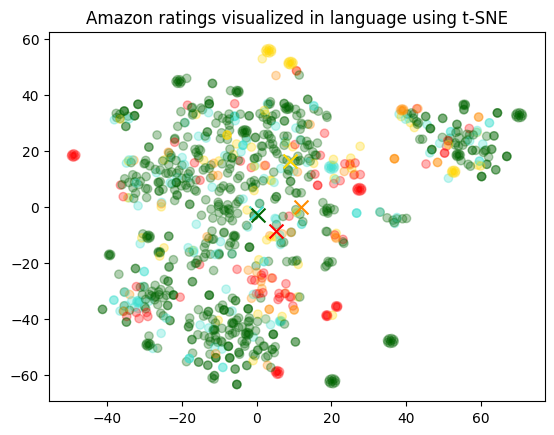

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

colors = ["red", "darkorange", "gold", "turquoise", "darkgreen"] #設定資料標示的顏色
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]
color_indices = df.Score.values - 1

colormap = matplotlib.colors.ListedColormap(colors)
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)
for score in [0,1,2,3,4]:
    avg_x = np.array(x)[df.Score-1==score].mean()
    avg_y = np.array(y)[df.Score-1==score].mean()
    color = colors[score]
    plt.scatter(avg_x, avg_y, marker='x', color=color, s=100)

plt.title("Amazon ratings visualized in language using t-SNE")#設定標題


###換成另一個embedding型態
*   此程式常常會當
*   如不想執行，可直接下載檔案 (改執行下面的wget命令，請把#註解拿掉)

In [ ]:
#def:定義函式
def get_embedding2(text, model="text-embedding-ada-002"): 
   text = text.replace("\n", " ")
   return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']

df['ada_embedding'] = df.combined.apply(lambda x: get_embedding2(x, model='text-embedding-ada-002'))
df.to_csv('embedded_1k_reviews.csv', index=False) #index = False 不寫索引名 , index = 0 則不寫列名

In [ ]:
# 如果不想執行上一格程式，可改執行下面wget命令
!wget https://github.com/joshhu/mustgpt2023/raw/main/Code/5/embedded_1k_reviews.csv

--2023-05-20 09:48:02--  https://github.com/joshhu/mustgpt2023/raw/main/Code/5/embedded_1k_reviews.csv
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/joshhu/mustgpt2023/main/Code/5/embedded_1k_reviews.csv [following]
--2023-05-20 09:48:02--  https://raw.githubusercontent.com/joshhu/mustgpt2023/main/Code/5/embedded_1k_reviews.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69669654 (66M) [text/plain]
Saving to: ‘embedded_1k_reviews.csv’

embedded_1k_reviews 100%[===================>]  66.44M   337MB/s    in 0.2s    

2023-05-20 09:48:02 (337 MB/s) - ‘embedded_1k_reviews.csv’ saved [69669654/

###重新畫一個圖，用新的程式

Text(0.5, 1.0, 'Amazon ratings visualized in language using t-SNE')

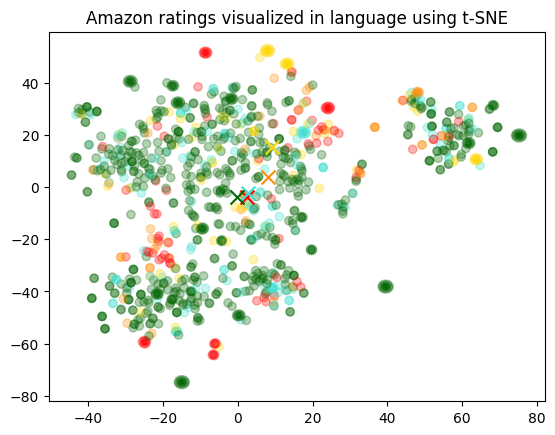

In [ ]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib

df = pd.read_csv('embedded_1k_reviews.csv')
matrix = np.array(df.ada_embedding.apply(eval).to_list())

# 創建 t-SNE 模型並轉換數據
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)

vis_dims = tsne.fit_transform(matrix)

colors = ["red", "darkorange", "gold", "turquoise", "darkgreen"]
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]
color_indices = df.Score.values - 1

colormap = matplotlib.colors.ListedColormap(colors)
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)
for score in [0,1,2,3,4]:
    avg_x = np.array(x)[df.Score-1==score].mean()
    avg_y = np.array(y)[df.Score-1==score].mean()
    color = colors[score]
    plt.scatter(avg_x, avg_y, marker='x', color=color, s=100)

plt.title("Amazon ratings visualized in language using t-SNE")

###使用這個embedding來做regression

In [ ]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

datafile_path = "fine_food_reviews_with_embeddings_1k.csv"

df = pd.read_csv(datafile_path)
df["embedding"] = df.embedding.apply(eval).apply(np.array)

X_train, X_test, y_train, y_test = train_test_split(list(df.embedding.values), df.Score, test_size=0.2, random_state=42)

rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(X_train, y_train) #訓練
preds = rfr.predict(X_test)

mse = mean_squared_error(y_test, preds)
mae = mean_absolute_error(y_test, preds)

print(f"ada-002 embedding performance on 1k Amazon reviews: mse={mse:.2f}, mae={mae:.2f}")

ada-002 embedding performance on 1k Amazon reviews: mse=0.61, mae=0.53


In [ ]:
bmse = mean_squared_error(y_test, np.repeat(y_test.mean(), len(y_test)))
bmae = mean_absolute_error(y_test, np.repeat(y_test.mean(), len(y_test)))
print(
    f"Dummy mean prediction performance on Amazon reviews: mse={bmse:.2f}, mae={bmae:.2f}"
)

Dummy mean prediction performance on Amazon reviews: mse=1.73, mae=1.03


###用這個embedding來作分類

In [ ]:
# imports 匯入套件
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# load data 載入數據
datafile_path = "fine_food_reviews_with_embeddings_1k.csv"

df = pd.read_csv(datafile_path)
df["embedding"] = df.embedding.apply(eval).apply(np.array)  # convert string to array 將字符串轉換為數組

# split data into train and test 將數據拆分為訓練和測試
X_train, X_test, y_train, y_test = train_test_split(
    list(df.embedding.values), df.Score, test_size=0.2, random_state=42
)

# train random forest classifier 訓練隨機樹狀分類器
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
probas = clf.predict_proba(X_test)

report = classification_report(y_test, preds)
print(report)

              precision    recall  f1-score   support

           1       0.88      0.35      0.50        20
           2       1.00      0.38      0.55         8
           3       1.00      0.18      0.31        11
           4       1.00      0.26      0.41        27
           5       0.74      1.00      0.85       134

    accuracy                           0.77       200
   macro avg       0.92      0.43      0.52       200
weighted avg       0.82      0.77      0.72       200



###繪製圖型

RandomForestClassifier() - Average precision score over all classes: 0.87


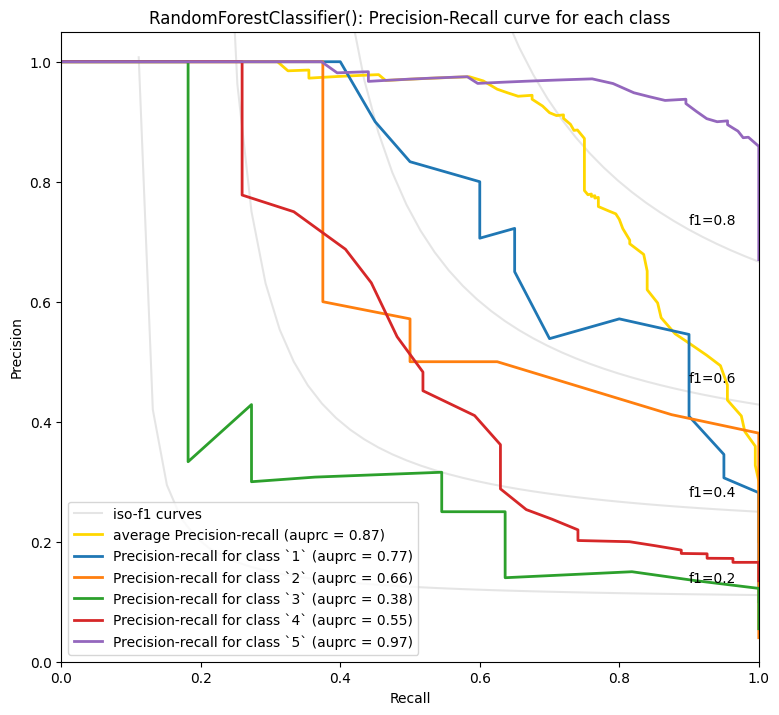

In [ ]:
from openai.embeddings_utils import plot_multiclass_precision_recall

plot_multiclass_precision_recall(probas, y_test, [1, 2, 3, 4, 5], clf)

###使用這個embedding來作zero-shot分類任務

In [ ]:
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report

# parameters 參數
EMBEDDING_MODEL = "text-embedding-ada-002"

# load data
datafile_path = "fine_food_reviews_with_embeddings_1k.csv"

df = pd.read_csv(datafile_path)
df["embedding"] = df.embedding.apply(eval).apply(np.array)

# convert 5-star rating to binary sentiment
df = df[df.Score != 3]
df["sentiment"] = df.Score.replace({1: "negative", 2: "negative", 4: "positive", 5: "positive"})

In [ ]:
from openai.embeddings_utils import cosine_similarity, get_embedding
from sklearn.metrics import PrecisionRecallDisplay

def evaluate_embeddings_approach(
    labels = ['negative', 'positive'], 
    model = EMBEDDING_MODEL,
):
    label_embeddings = [get_embedding(label, engine=model) for label in labels]

    def label_score(review_embedding, label_embeddings):
        return cosine_similarity(review_embedding, label_embeddings[1]) - cosine_similarity(review_embedding, label_embeddings[0])

    probas = df["embedding"].apply(lambda x: label_score(x, label_embeddings))
    preds = probas.apply(lambda x: 'positive' if x>0 else 'negative')

    report = classification_report(df.sentiment, preds)
    print(report)

    display = PrecisionRecallDisplay.from_predictions(df.sentiment, probas, pos_label='positive')
    _ = display.ax_.set_title("2-class Precision-Recall curve")

evaluate_embeddings_approach(labels=['negative', 'positive'], model=EMBEDDING_MODEL)

In [ ]:
evaluate_embeddings_approach(labels=['An Amazon review with a negative sentiment.', 'An Amazon review with a positive senti

In [ ]:
evaluate_embeddings_approach(labels=['An Amazon review with a negative sentiment.', 'An Amazon review with a positive senti

###做clustering

In [ ]:
# imports
import numpy as np
import pandas as pd

# load data
datafile_path = "fine_food_reviews_with_embeddings_1k.csv"

df = pd.read_csv(datafile_path)
df["embedding"] = df.embedding.apply(eval).apply(np.array)  # convert string to numpy array
matrix = np.vstack(df.embedding.values)
matrix.shape

In [ ]:
from sklearn.cluster import KMeans

n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
df["Cluster"] = labels

df.groupby("Cluster").Score.mean().sort_values() #groupby:分組操作

In [ ]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue"]):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")

###使用embedding做語義搜尋

In [ ]:
import pandas as pd
import numpy as np

datafile_path = "fine_food_reviews_with_embeddings_1k.csv"

df = pd.read_csv(datafile_path)
df["embedding"] = df.embedding.apply(eval).apply(np.array)

In [ ]:
from openai.embeddings_utils import get_embedding, cosine_similarity

#搜索特定產品的評論
def search_reviews(df, product_description, n=3, pprint=True):
    product_embedding = get_embedding(
        product_description,
        engine="text-embedding-ada-002"
    )
    df["similarity"] = df.embedding.apply(lambda x: cosine_similarity(x, product_embedding))

    results = (
        df.sort_values("similarity", ascending=False)
        .head(n)
        .combined.str.replace("Title: ", "")
        .str.replace("; Content:", ": ")
    )
    if pprint:
        for r in results:
            print(r[:200])
            print()
    return results


results = search_reviews(df, "delicious beans", n=3)

In [ ]:
results = search_reviews(df, "whole wheat pasta", n=3)

In [ ]:
results = search_reviews(df, "bad delivery", n=1)

In [ ]:
results = search_reviews(df, "spoilt", n=1)

In [ ]:
results = search_reviews(df, "pet food", n=2)